In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy import poly1d, polyfit, power
import scipy.optimize
from math import *
from IPython.display import HTML
from IPython.display import Image
import os
import pandas as pd
import PIL as pil
import heapq
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 18, 14
# import seaborn as sns
# sns.set_palette("deep", desat=.6)

try:
    from PIL import Image
except:
    import Image
    
incl = 30.

sin_i2 = np.sin(incl*np.pi/180.)**2
cos_i2 = np.cos(incl*np.pi/180.)**2

[]

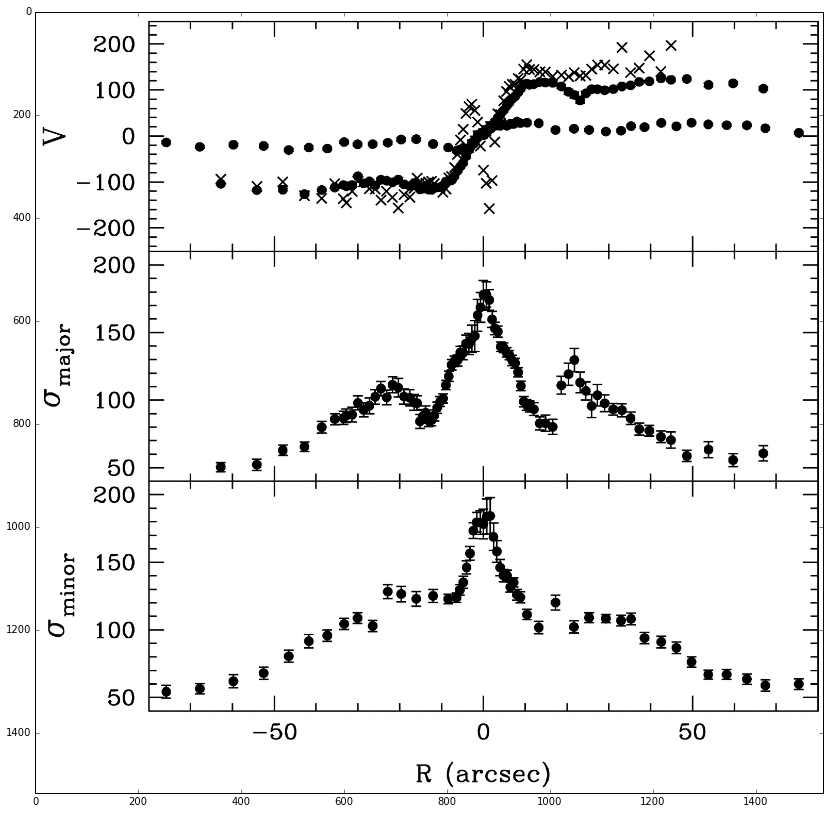

In [47]:
os.chdir("C:\\science\\2FInstability\\data\\ngc1068")

plt.imshow(np.asarray(Image.open("shapiro_fg3a.png")))
plt.plot()

[]

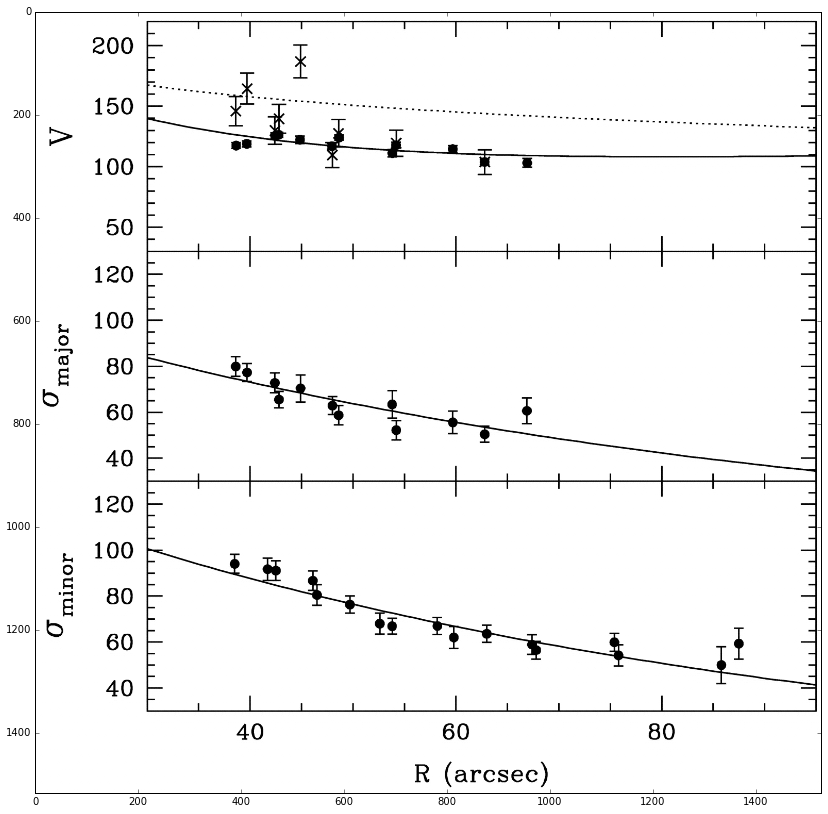

In [48]:
plt.imshow(np.asarray(Image.open("shapiro_fg4a.png")))
plt.plot()

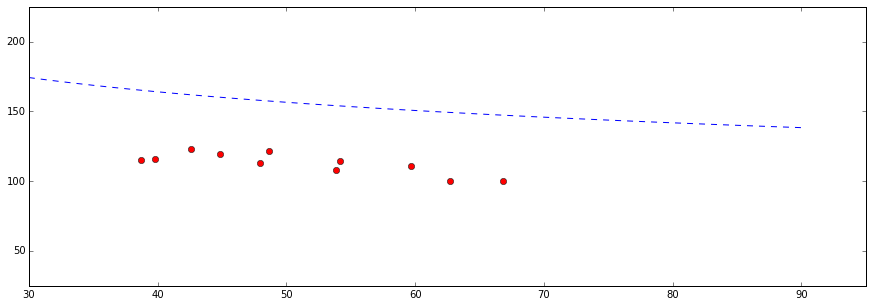

In [49]:
pylab.rcParams['figure.figsize'] = 15, 5

#Velocity
lu = (215, 67)
lu_val = (30, 200)
rd = (1217, 463)
rd_val = (80, 25)

data = [(389,259), (411,257), (467,241), (513,249), (575,263), (589,245), (693,275), (699,261), (809,269), (871,293), (953,293)]

def extend_values(data, lu, lu_val, rd, rd_val):
    xscale = 1.0*(rd_val[0]-lu_val[0])/(rd[0]-lu[0])
    yscale = 1.0*(rd_val[1]-lu_val[1])/(lu[1]-rd[1])
    extended = []
    for d in data:
        extended.append((xscale*(d[0]-lu[0])+lu_val[0], yscale*(rd[1] - d[1])+rd_val[1]))
    return extended
        
e_data = extend_values(data, lu, lu_val, rd, rd_val)
plt.plot(zip(*e_data)[0],zip(*e_data)[1], 'or')

vel_fit = lambda l: 356.*np.power(l, -0.21)
plt.plot(np.linspace(30., 90., 100), map(vel_fit, np.linspace(30., 90., 100)), '--')
plt.ylim(25, 225)
plt.xlim(30, 95)
plt.show()

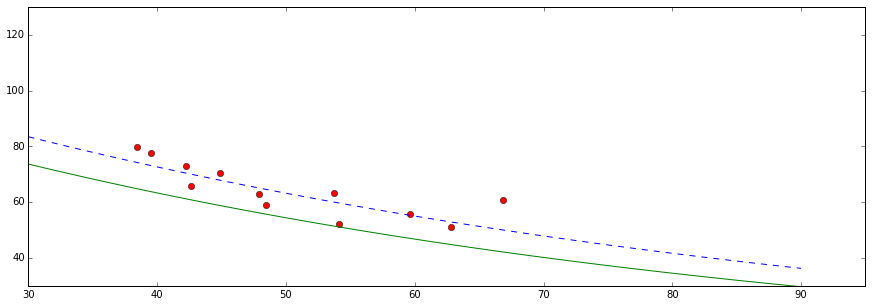

In [50]:
#Sig_maj
lu = (219, 509)
lu_val = (30, 120)
rd = (1215, 913)
rd_val = (80, 30)

data = [(387,689), (409,699), (463,721), (471,753), (515,731), (575,765), (587,783), (691,763), (699,813), (809,797), (873,819), (953,775)]

sig_maj_data = extend_values(data, lu, lu_val, rd, rd_val)
plt.plot(zip(*sig_maj_data)[0],zip(*sig_maj_data)[1], 'or')

sigR = lambda l: 213.*np.exp(-l/72.)
sigZ = lambda l: 124.*np.exp(-l/72.)
phi_to_R = lambda l: 0.5*(1 - 0.21)

sigR_min = lambda l: 193.*np.exp(-l/66.)
sigZ_min = lambda l: 115.*np.exp(-l/66.)
phi_to_R_min = lambda l: 0.5*(1 - 0.24)

sig_maj = lambda l: sqrt(sigR(l)**2 * (phi_to_R(l) * sin_i2 + sigZ(l)**2 * cos_i2/sigR(l)**2))
sig_maj_min = lambda l: sqrt(sigR_min(l)**2 * (phi_to_R_min(l) * sin_i2 + sigZ_min(l)**2 * cos_i2/sigR_min(l)**2))

plt.plot(np.linspace(30., 90., 100), map(sig_maj, np.linspace(30., 90., 100)), '--')
plt.plot(np.linspace(30., 90., 100), map(sig_maj_min, np.linspace(30., 90., 100)), '-')
plt.ylim(30, 130)
plt.xlim(30, 95)
plt.show()

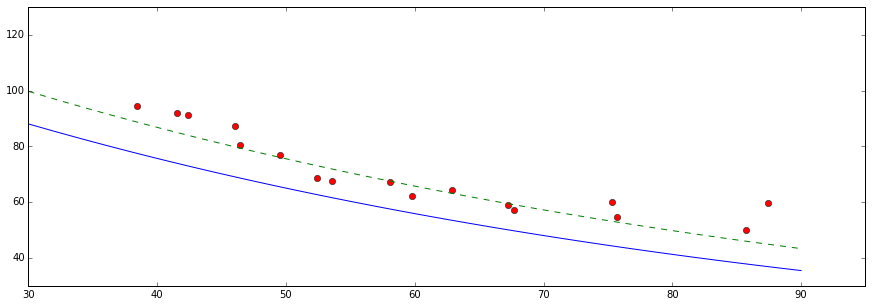

In [51]:
#Sig_min
lu = (219, 957)
lu_val = (30, 120)
rd = (1217, 1359)
rd_val = (80, 30)

data = [(387,1071), (449,1083), (467,1085), (539,1103), (547,1133), (609,1149), (667,1187), (689,1191), (779,1193), (813,1215), 
        (875,1205), (963,1229), (971,1237), (1123,1225), (1131,1249), (1331,1269), (1365,1227)]

sig_min_data = extend_values(data, lu, lu_val, rd, rd_val)
plt.plot(zip(*sig_min_data)[0], zip(*sig_min_data)[1], 'or')

sig_min = lambda l: sqrt(sigR(l)**2 * sin_i2 + sigZ(l)**2 * cos_i2)
sig_min_min = lambda l: sqrt(sigR_min(l)**2 * sin_i2 + sigZ_min(l)**2 * cos_i2)

plt.plot(np.linspace(30., 90., 100), map(sig_min_min, np.linspace(30., 90., 100)), '-')
plt.plot(np.linspace(30., 90., 100), map(sig_min, np.linspace(30., 90., 100)), '--')
plt.ylim(30, 130)
plt.xlim(30, 95)
plt.show()

In [52]:
h_kin = 72.
beta = 0.21

def sig_maj_exp(R):
    global alpha, sigR_0, h_kin, beta
    return np.exp(-R/h_kin)*sigR_0*sqrt(0.5*(1 - beta) * sin_i2 + alpha**2 * cos_i2)

def sig_min_exp(R):
    global alpha, sigR_0, h_kin
    return np.exp(-R/h_kin)*sigR_0*sqrt(sin_i2 + alpha**2 * cos_i2)

alphas = np.arange(0.25, 1., 0.01)
sigmas = np.arange(80.0, 250, 0.25)

def compute_chi2_maps(alph=(), sigm=()):
    '''Вычисляем все изображения, чтобы потом только настройки менять'''
    image_min = np.random.uniform(size=(len(sigm), len(alph)))
    image_maj = np.random.uniform(size=(len(sigm), len(alph)))
    image = np.random.uniform(size=(len(sigmas), len(alphas)))
    for i,si in enumerate(sigm):
        for j,al in enumerate(alph):
            global alpha, sigR_0
            alpha = al
            sigR_0 = si
            sqerr_maj = sum(power([sig_maj_exp(p[0]) - p[1] for p in sig_maj_data], 2))/len(sig_maj_data)
            sqerr_min = sum(power([sig_min_exp(p[0]) - p[1] for p in sig_min_data], 2))/len(sig_min_data)
            image_maj[i][j] = sqerr_maj
            image_min[i][j] = sqerr_min
    return image_maj, image_min

pics_path = "C:\\science\\2FInstability\\data\\ngc1068\\"
if not os.path.exists(pics_path):
    os.makedirs(pics_path)
if os.path.isfile(pics_path + 'chi2_map_maj.npy'):
    image_maj = np.load(pics_path + "chi2_map_maj.npy")
    image_min = np.load(pics_path + "chi2_map_min.npy")
else:
    image_maj, image_min = compute_chi2_maps(alphas=alphas, sigmas=sigmas)
    np.save(pics_path + 'chi2_map_maj', image_maj)
    np.save(pics_path + 'chi2_map_min', image_min)

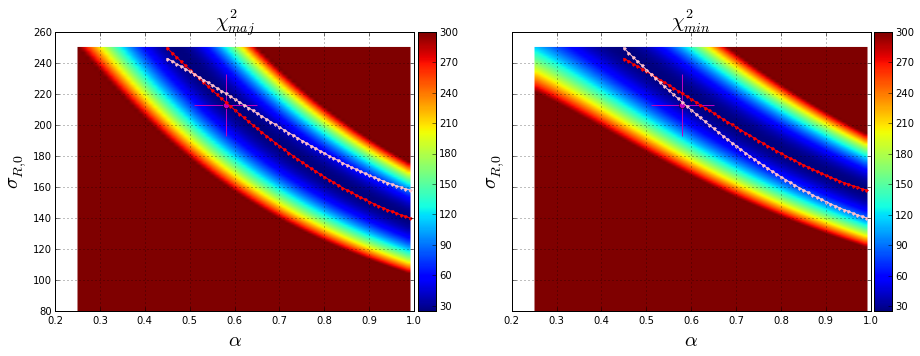

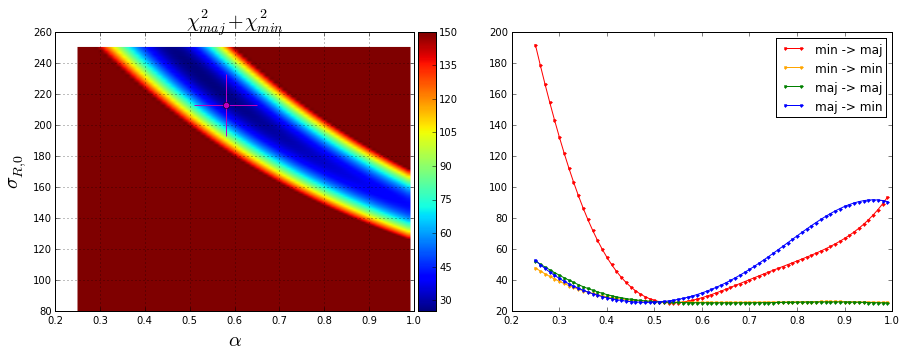

In [53]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_chi2_map(image, ax, log_scale=False, title='$\chi^2$', is_contour=False, vmax=0.):
    if image is not None:
        im = ax.imshow(image, cmap='jet', vmin=image.min(), vmax=vmax, interpolation='spline16', 
                   origin="lower", extent=[alphas[0], alphas[-1],sigmas[0],sigmas[-1]], aspect="auto")
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)
        ax.set_title(title, size=20.)
        ax.set_ylabel('$\sigma_{R,0}$', size=20.)
        ax.set_xlabel(r'$\alpha$', size=20.)
        ax.grid(True)
        
min_sigmas = np.where(image_min < image_min.min() + 10.)
slice_alph, slice_sig = min_sigmas[1], min_sigmas[0]
slice_alph = map(lambda l: alphas[0] + (alphas[-1] - alphas[0])*l/len(image_min[0]) , slice_alph)
slice_sig = map(lambda l: sigmas[0] + (sigmas[-1] - sigmas[0])*l/len(image_min), slice_sig)
poly_slice_min = poly1d(polyfit(slice_alph, slice_sig, deg=3))
maj_sigmas = np.where(image_maj < image_maj.min() + 10.)
slice_alph, slice_sig = maj_sigmas[1], maj_sigmas[0]
slice_alph = map(lambda l: alphas[0] + (alphas[-1] - alphas[0])*l/len(image_maj[0]) , slice_alph)
slice_sig = map(lambda l: sigmas[0] + (sigmas[-1] - sigmas[0])*l/len(image_maj), slice_sig)
poly_slice_maj = poly1d(polyfit(slice_alph, slice_sig, deg=3))
       
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, figsize=[15,5])
plot_chi2_map(image_maj, axes[0], log_scale=False, title='$\chi^2_{maj}$', is_contour=False, vmax=300.)
plot_chi2_map(image_min, axes[1], log_scale=False, title='$\chi^2_{min}$', is_contour=False, vmax=300.)
axes[0].plot(0.58, 213., 'o', color='m')
axes[0].errorbar(0.58, 213., xerr=0.07, yerr=20., fmt='.', marker='.', mew=0, color='m')
axes[0].plot(alphas[20:], map(poly_slice_maj, alphas[20:]), '.-', label = 'maj -> maj', color= 'red')
axes[0].plot(alphas[20:], map(poly_slice_min, alphas[20:]), '.-', label = 'min -> maj', color= 'pink')
axes[1].plot(0.58, 213., 'o', color='m')
axes[1].errorbar(0.58, 213., xerr=0.07, yerr=20., fmt='.', marker='.', mew=0, color='m')
axes[1].plot(alphas[20:], map(poly_slice_min, alphas[20:]), '.-', label = 'min -> min', color='red')
axes[1].plot(alphas[20:], map(poly_slice_maj, alphas[20:]), '.-', label = 'maj -> min', color='pink') 
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=[15,5])
plot_chi2_map((image_min + image_maj)/2, axes[0], log_scale=False, title='$\chi^2_{maj}+\chi^2_{min}$', is_contour=False, vmax=150.)
axes[0].plot(0.58, 213., 'o', color='m')
axes[0].errorbar(0.58, 213., xerr=0.07, yerr=20., fmt='.', marker='.', mew=0, color='m')

err_maj_1, err_maj_2 = [], []
err_min_1, err_min_2 = [], []
for al in alphas:
    global alpha, sigR_0
    alpha = al
    sigR_0 = poly_slice_min(alpha)
    err_maj_1.append(sum(power([sig_maj_exp(p[0]) - p[1] for p in sig_maj_data], 2))/len(sig_maj_data))
    err_min_1.append(sum(power([sig_min_exp(p[0]) - p[1] for p in sig_min_data], 2))/len(sig_min_data))
    sigR_0 = poly_slice_maj(alpha)
    err_maj_2.append(sum(power([sig_maj_exp(p[0]) - p[1] for p in sig_maj_data], 2))/len(sig_maj_data))
    err_min_2.append(sum(power([sig_min_exp(p[0]) - p[1] for p in sig_min_data], 2))/len(sig_min_data))
    
axes[1].plot(alphas, err_maj_1, '.-', label = 'min -> maj', color= 'red')
axes[1].plot(alphas, err_min_1, '.-', label = 'min -> min', color='orange')
axes[1].plot(alphas, err_maj_2, '.-', label = 'maj -> maj', color= 'green')
axes[1].plot(alphas, err_min_2, '.-', label = 'maj -> min', color='blue') 
axes[1].legend()

plt.show()

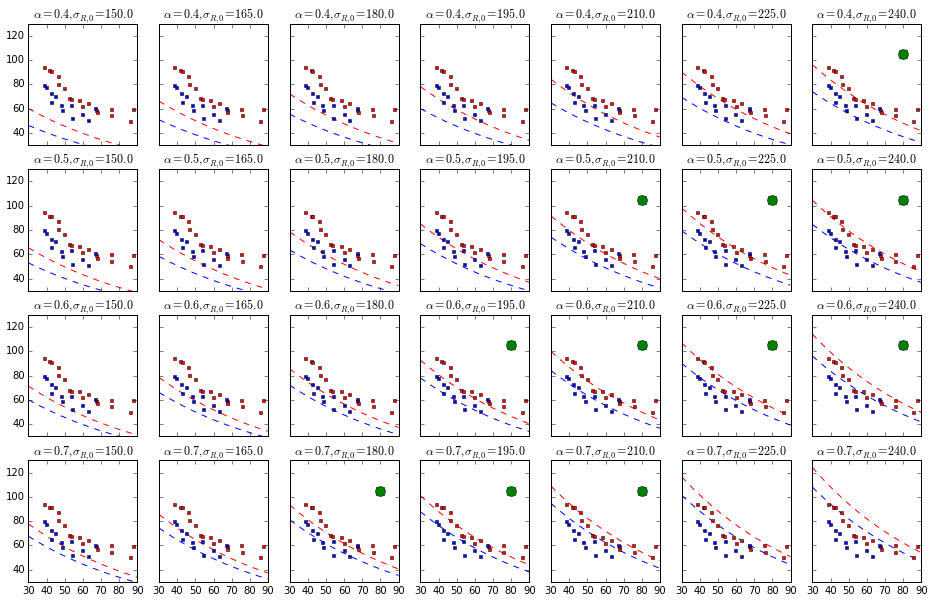

In [54]:
alphas = np.arange(0.4, 0.8, 0.1)
sigmas = np.arange(150., 250., 15.)
points = np.arange(30., 90., 0.1)
good_pics = []

def plot_ranges_gers(sigmas_range, alphas_range, good_pics=[], calc_chi=False, best_err=3):
    nrows = alphas.size
    ncols = sigmas.size
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=[16,10])
    plt_index = 0
    # Последнее - среднее геометрическое
    sqerr_majs, sqerr_mins, sqerr_mean = [],[],[]
    for al in alphas_range:
        for si in sigmas_range:
            global alpha, sigR_0
            alpha = al
            sigR_0 = si
            ax = axes[plt_index/ncols, plt_index % ncols]
            ax.set_title(r'$\alpha = %s, \sigma_{R,0}=%s$' % (al,si))
            
            sqerr_maj = sum(power([sig_maj_exp(p[0]) - p[1] for p in sig_maj_data], 2))/len(sig_maj_data)
            sqerr_min = sum(power([sig_min_exp(p[0]) - p[1] for p in sig_min_data], 2))/len(sig_min_data)
            if sqerr_maj < 120. and sqerr_min < 120.:
                ax.plot(80., 105., 'og', ms = 10)
            
            ax.plot(points, [sig_maj_exp(R) for R in points], '--', color='blue')
            ax.plot(points, [sig_min_exp(R) for R in points], '--', color='red')
            ax.plot(zip(*sig_min_data)[0],zip(*sig_min_data)[1], 's', color='red', ms=3)
            ax.plot(zip(*sig_maj_data)[0],zip(*sig_maj_data)[1], 's', color='blue', ms=3)
            ax.set_ylim(30, 130)
            ax.set_xlim(30, 90)
            plt_index = plt_index + 1
    

plot_ranges_gers(sigmas, alphas, good_pics=good_pics, calc_chi=True)
plt.show()

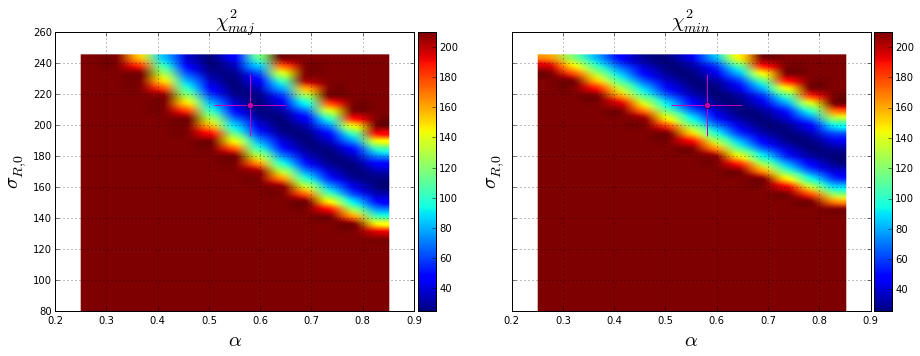

In [55]:
from IPython.html.widgets import *

def widget_plot_maps(h_k, b, vm, contour_swap):
    global alpha, sigR_0, h_kin, beta, alphas, sigmas
    h_kin = h_k
    beta = b
    alphas = np.arange(0.25, 0.9, 0.05)
    sigmas = np.arange(80.0, 250, 5.)
    image_maj, image_min = compute_chi2_maps(alph=alphas, sigm=sigmas)    
    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, figsize=[15,5])
    plot_chi2_map(image_maj, axes[0], log_scale=False, title='$\chi^2_{maj}$', is_contour=False, vmax=vm)
    plot_chi2_map(image_min, axes[1], log_scale=False, title='$\chi^2_{min}$', is_contour=False, vmax=vm)
    
    if contour_swap:
        norm = cm.colors.Normalize(vmax=image_min.max(), vmin=-image_min.max())
        cmap = cm.PRGn
        levels = np.linspace(start=image_min.min(), stop=vm, num=10)
        cset=axes[0].contour(image_min, levels, hold='on', colors = 'k', origin='lower', 
                             extent=[alphas[0],alphas[-1],sigmas[0],sigmas[-1]])
        norm = cm.colors.Normalize(vmax=image_maj.max(), vmin=-image_maj.max())
        cmap = cm.PRGn
        levels = np.linspace(start=image_maj.min(), stop=vm, num=10)
        cset=axes[1].contour(image_maj, levels, hold='on', colors = 'k', origin='lower', 
                             extent=[alphas[0],alphas[-1],sigmas[0],sigmas[-1]])
    
    axes[0].plot(0.58, 213., 'o', color='m')
    axes[0].errorbar(0.58, 213., xerr=0.07, yerr=20., fmt='.', marker='.', mew=0, color='m')
    axes[1].plot(0.58, 213., 'o', color='m')
    axes[1].errorbar(0.58, 213., xerr=0.07, yerr=20., fmt='.', marker='.', mew=0, color='m')
    plt.show()

interact(widget_plot_maps, h_k=(60, 80, 0.5), b=(0.15, 0.25, 0.01), vm = (70., 350., 10),  contour_swap=False);

#Выше был пример построения на основе данных Герсена и Шапиро и их аппроксимаций. Ниже попробуем использовать наш подход:

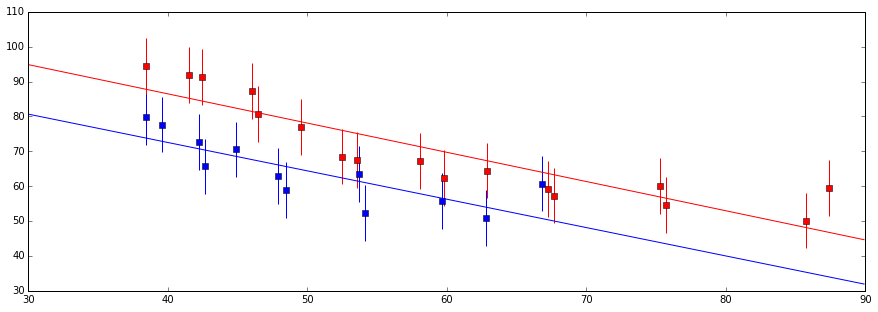

In [56]:
import scipy.interpolate as inter

radii_maj, sig_maj_p = zip(*sig_maj_data)
e_sig_maj_p = [8]*len(radii_maj)
spl_maj = inter.UnivariateSpline (radii_maj[::-1], sig_maj_p[::-1], k=1, s=10000)

radii_min, sig_min_p = zip(*sig_min_data)
e_sig_min_p = [8]*len(radii_min)
spl_min = inter.UnivariateSpline (radii_min[::-1], sig_min_p[::-1], k=1, s=10000)

plt.plot(radii_maj, sig_maj_p, 's', label='$\sigma_{los}^{maj}$', color='blue')
plt.errorbar(radii_maj, sig_maj_p, yerr=e_sig_maj_p, fmt='.', marker='.', mew=0, color='blue')
plt.plot(points, spl_maj(points), label = '$\sigma_{los}^{maj}\, splinefit$', color='blue')
plt.plot(radii_min, sig_min_p, 's', label='$\sigma_{los}^{min}$', color='red')
plt.errorbar(radii_min, sig_min_p, yerr=e_sig_min_p, fmt='.', marker='.', mew=0, color='red')
plt.plot(points, spl_min(points), label = '$\sigma_{los}^{min}\, splinefit$', color='red')

plt.show()

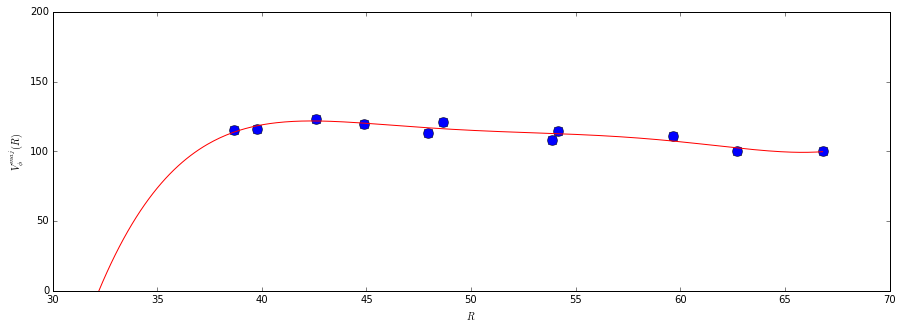

In [57]:
from numpy import poly1d, polyfit, power

r_ma_b, vel_ma_b = zip(*e_data)
poly_star = poly1d(polyfit(r_ma_b, vel_ma_b, deg=5))

plt.plot(r_ma_b, vel_ma_b, 'o', color='blue', markersize=10)
test_points = np.arange(0.0, max(r_ma_b), 0.1)
plt.plot(test_points, poly_star(test_points), '-', color='red')
plt.xlabel('$R$')
plt.ylim(0, 200)
plt.xlim(30, 70)
plt.ylabel('$V^{maj}_{\phi}(R)$')
plt.show()

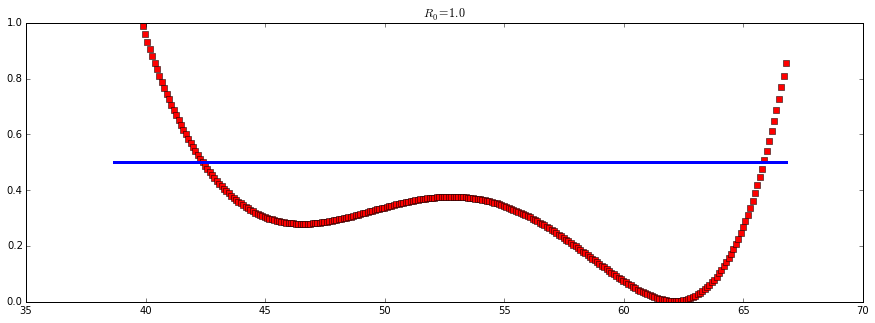

In [58]:
def sigPhi_to_sigR_real(R):
        return 0.5 * (1 + R*poly_star.deriv()(R) / poly_star(R))

test_points = np.arange(min(r_ma_b), max(r_ma_b), 0.1)

def f(R, Ro):
    return 0.5*(1 + np.exp( -R/Ro ))

xdata = test_points
ydata = sigPhi_to_sigR_real(xdata)

# xdata[0] = 0
# ydata[0] = 0

from scipy.optimize import curve_fit
popt, pcov = curve_fit(f, xdata, ydata, p0=[1.0])
Ro = popt[0]

plt.plot(xdata, ydata, 's', color='r')
plt.plot(xdata, [f(p, Ro) for p in xdata], '-', linewidth=3.0, color='b')
# plt.axhline(y=0.5)
plt.axhline(y=0.0)
plt.title('$R_{0} = %s $' % Ro)
plt.ylim(0, 1)
plt.show()

def sigPhi_to_sigR(R):
    return sqrt(f(R, Ro))

In [59]:
#Значение sig_los_min в cutted
sig_min_0 = spl_min(radii_min[0])

#Значение sig_R в cutted
sig_R_0 = 100.

alpha = 0.5

def sigR_exp(R):
    return sig_R_0*spl_min(R)/sig_min_0

def sigZ_exp(R):
    return alpha * sigR_exp(R)

def sigPhi_exp(R):
    return sigPhi_to_sigR(R) * sigR_exp(R)

def sig_maj_exp(R):
    return sqrt(sigPhi_exp(R)**2 * sin(incl*pi/180)**2 + sigZ_exp(R)**2 * cos(incl*pi/180)**2)

def sig_min_exp(R):
    return sqrt(sigR_exp(R)**2 * sin(incl*pi/180)**2 + sigZ_exp(R)**2 * cos(incl*pi/180)**2)

In [60]:
alphas = np.arange(0.25, 1., 0.01)
sigmas = np.arange(50.0, 200, 1.)

def calc_chi2_normal(obs, obserr, predicted):
    return sum([(o-p)**2/err**2 for (o,p,err) in zip(obs, predicted, obserr)])/len(obs)

def compute_chi2_maps(alphas=(), sigmas=()):
    '''Вычисляем все изображения, чтобы потом только настройки менять'''
    image_min = np.random.uniform(size=(len(sigmas), len(alphas)))
    image_maj = np.random.uniform(size=(len(sigmas), len(alphas)))
    image = np.random.uniform(size=(len(sigmas), len(alphas)))
    for i,si in enumerate(sigmas):
        for j,al in enumerate(alphas):
            global alpha, sig_R_0
            alpha = al
            sig_R_0 = si
            sqerr_maj = calc_chi2_normal(sig_maj_p, e_sig_maj_p, [sig_maj_exp(r) for r in radii_maj])
            sqerr_min = calc_chi2_normal(sig_min_p, e_sig_min_p, [sig_min_exp(r) for r in radii_min])
            sqerr_sum = 0.5*sqerr_maj+0.5*sqerr_min
            image[i][j] = sqerr_sum
            image_maj[i][j] = sqerr_maj
            image_min[i][j] = sqerr_min
    return image, image_maj, image_min

image, image_maj, image_min = compute_chi2_maps(alphas=alphas, sigmas=sigmas)

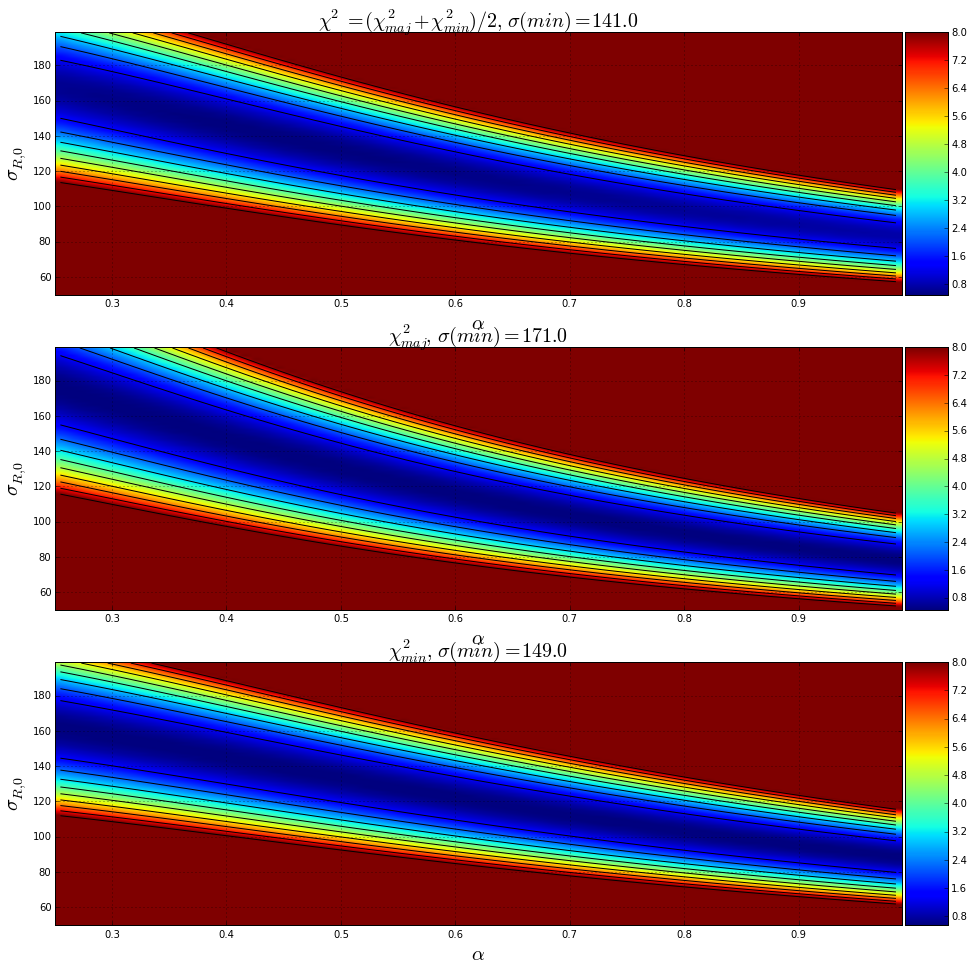

In [61]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm

def plot_chi2_map(image, ax, log_scale=False, title='$\chi^2$', is_contour=False, vmax=0.):
    if image is not None:
        if log_scale:
            image_log = np.apply_along_axis(np.log, 1, image)
            vmax = image_log.max()
        else:
            image_log = image
        if is_contour:
            norm = cm.colors.Normalize(vmax=image.max(), vmin=-image.max())
            cmap = cm.PRGn
            levels = np.linspace(start=image_log.min(), stop=vmax, num=10)
            cset=ax.contour(image_log, levels, hold='on', colors = 'k', origin='lower', extent=[alphas[0],alphas[-1],sigmas[0],sigmas[-1]])
        im = ax.imshow(image_log, cmap='jet', vmin=image_log.min(), vmax=vmax, interpolation='spline16', 
                   origin="lower", extent=[alphas[0], alphas[-1],sigmas[0],sigmas[-1]], aspect="auto")
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)
        min_sigma = sigmas[int(np.where(image == image.min())[0])]        
        ax.set_title(title + '$,\ \sigma(min)=%s$' % min_sigma, size=20.)
        ax.set_ylabel('$\sigma_{R,0}$', size=20.)
        ax.set_xlabel(r'$\alpha$', size=20.)
        ax.grid(True)
 
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=False, sharey=True, figsize=[16,16])
plot_chi2_map(image, axes[0], log_scale=False, title='$\chi^2 = (\chi^2_{maj} + \chi^2_{min})/2$', is_contour=True, vmax=8.)
plot_chi2_map(image_maj, axes[1], log_scale=False, title='$\chi^2_{maj}$', is_contour=True, vmax=8.)
plot_chi2_map(image_min, axes[2], log_scale=False, title='$\chi^2_{min}$', is_contour=True, vmax=8.)
plt.show()

In [62]:
tex_imgs_dir = "C:\\Users\\root\\Dropbox\\RotationCurves\\PhD\\paper1\\text\\imgs"
try: 
    os.chdir(tex_imgs_dir)
except:
    tex_imgs_dir = "C:\\Users\\Alex March\\Dropbox\\RotationCurves\\PhD\\paper1\\text\\imgs"
os.chdir(tex_imgs_dir)

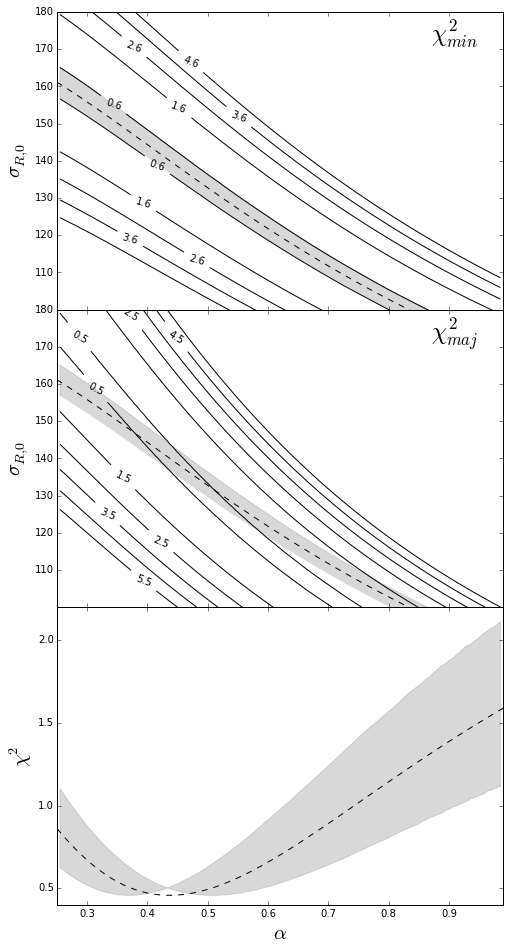

In [63]:
cos_i, sin_i = cos(incl * pi / 180), sin(incl * pi / 180)
main_slice = lambda l: sig_min_0/sqrt(sin_i**2 + cos_i**2 * l**2)


import matplotlib.mlab as mlab
import matplotlib

fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=False, figsize=[8,16])
ax = axes[0]
levels = np.linspace(start=image_min.min()*1.1, stop=image_min.min()*1.1+4, num=5)
cset=ax.contour(image_min, levels,  colors = 'k', origin='lower', extent=[alphas[0],alphas[-1],sigmas[0],sigmas[-1]])
min_map_gutter = cset.collections[0].get_paths()

v1,v2 = min_map_gutter[1].vertices, min_map_gutter[0].vertices
x1,x2 = v1[:,0], v2[:,0]
y1,y2 = v1[:,1], v2[:,1]
plt.clabel(cset, inline=1, fontsize=10, fmt='%1.1f',)
ax.text(0.87, 172, '$\chi^2_{min}$', size = 24.)
ax.set_ylabel('$\sigma_{R,0}$', size=20.)
xx = np.arange(0.25, 1.0, 0.01)
ax.plot(xx, map(main_slice, xx), '--', color='black')
ax.set_ylim(100, 180)


min_sigmas = np.where(image_min < image_min.min() + 0.03)
slice_alph, slice_sig = min_sigmas[1], min_sigmas[0]
slice_alph = map(lambda l: alphas[0] + (alphas[-1] - alphas[0])*l/len(image_min[0]) , slice_alph)
slice_sig = map(lambda l: sigmas[0] + (sigmas[-1] - sigmas[0])*l/len(image_min), slice_sig)
# ax.plot(slice_alph, slice_sig, '.', color='pink')
poly_slice = poly1d(polyfit(slice_alph, slice_sig, deg=3))
# ax.plot(xx, poly_slice(xx), '.-', color='black')
ax.fill_between(x1, y1, 0, color='gray', alpha=0.3)
ax.fill_between(x2, y2, 0, color='white')

ax = axes[1]
levels = np.append(np.linspace(start=image_maj.min()+0.1, stop=image_maj.min()+4.1, num=6), np.array([image_maj.min()+0.25]))
levels = np.linspace(start=image_maj.min()*1.1, stop=image_maj.min()*1.1+5, num=6)
cset=ax.contour(image_maj, levels, hold='on', colors = 'k', origin='lower', extent=[alphas[0],alphas[-1],sigmas[0],sigmas[-1]])
plt.clabel(cset, inline=1, fontsize=10, fmt='%1.1f',)
ax.text(0.87, 172, '$\chi^2_{maj}$', size = 24.)
ax.set_ylabel('$\sigma_{R,0}$', size=20.)
xx = np.arange(0.25, 1.0, 0.01)
ax.plot(xx, map(main_slice, xx), '--', color='black')

ax.fill_between(x1, y1, 0, color='gray', alpha=0.3)
ax.fill_between(x2, y2, 0, color='white')
ax.set_ylim(100, 180)

ax = axes[2]
err_maj = []
for al in alphas:
    global alpha, sig_R_0
    alpha = al
    sig_R_0 = main_slice(al)
    sqerr_maj = calc_chi2_normal(sig_maj_p, e_sig_maj_p, [sig_maj_exp(r) for r in radii_maj])
    err_maj.append(sqerr_maj)
ax.plot(alphas, err_maj, '--', color='black')
err_maj1 = []
for pa in zip(x2,y2):
    global alpha, sig_R_0
    alpha = pa[0]
    sig_R_0 = pa[1]
    sqerr_maj = calc_chi2_normal(sig_maj_p, e_sig_maj_p, [sig_maj_exp(r) for r in radii_maj])
    err_maj1.append(sqerr_maj)
# ax.plot(x2, err_maj1, '-', color='black')
err_maj2 = []
for pa in zip(x1,y1):
    global alpha, sig_R_0
    alpha = pa[0]
    sig_R_0 = pa[1]
    sqerr_maj = calc_chi2_normal(sig_maj_p, e_sig_maj_p, [sig_maj_exp(r) for r in radii_maj])
    err_maj2.append(sqerr_maj)
# ax.plot(x1, err_maj2, '-', color='black')
ax.set_ylabel(r'$\chi^2$', size=20.)
ax.set_xlabel(r'$\alpha$', size=20.)


import scipy.interpolate as sp
f1 = sp.interp1d(x2, err_maj1, kind='linear')
# ax.fill_between(x1, map(f1, x1), err_maj2, color='grey', alpha=0.3)
f2 = sp.interp1d(x1, err_maj2, kind='linear')
ax.fill_between(x2, map(f2, x2), err_maj1, color='grey', alpha=0.3)

ax.set_ylabel(r'$\chi^2$', size=20.)
ax.set_xlabel(r'$\alpha$', size=20.)

# ax.set_ylim(3., 3.8)


fig.subplots_adjust(hspace=0.)
axes[0].yaxis.get_major_ticks()[0].set_visible(False)
axes[1].yaxis.get_major_ticks()[0].set_visible(False)
ax.set_xlim(0.25, 0.99)

plt.savefig('ngc1068_maps.eps', format='eps')
plt.savefig('ngc1068_maps.png', format='png')
plt.savefig('ngc1068_maps.pdf', format='pdf', dpi=150)

plt.show()